# Sentiment Analysis in Python 
 
in this notebook we will doing sentiment analysis in python using two diffrent techniques :

1. Vader (Valence Aware Dictionary and sEtiment Reasoner) => Bag of words aproach.    

2.Roberta Pretrained Model from the Huggingface Pipeline .


# Step 0 : Read in Data and NLTK Basics

In [24]:
import kagglehub
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 


plt.style.use('ggplot')

import nltk

 

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hassa\.cache\kagglehub\datasets\snap\amazon-fine-food-reviews\versions\2


In [25]:
import os
import pandas as pd


print("Files in the dataset folder:", os.listdir(path))


csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)


df = pd.read_csv(csv_path)


Files in the dataset folder: ['database.sqlite', 'hashes.txt', 'Reviews.csv']


In [26]:


df = df.head(500)
print( df.shape)
df.head()


(500, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...



# Quick EDA 

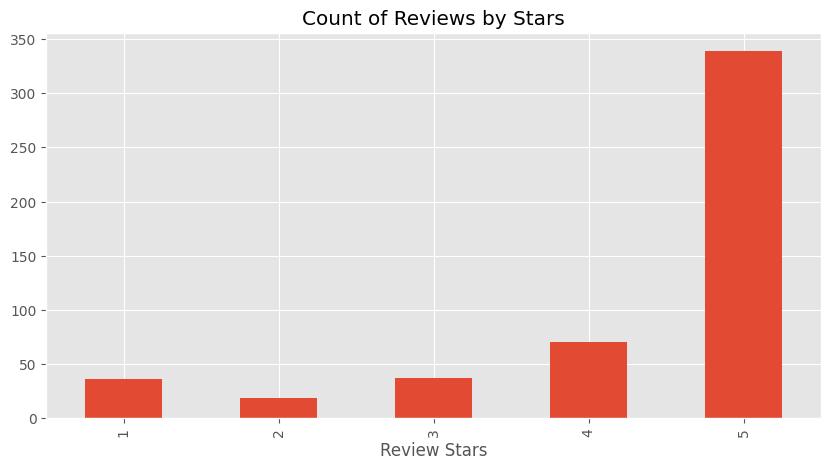

In [27]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind = 'bar', title= 'Count of Reviews by Stars',
          figsize=(10,5))

ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK 

In [28]:

example = df['Text'][50]
print( example)

tokens = nltk.word_tokenize(example, preserve_line=True)

print("Tokens:", tokens)


This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
Tokens: ['This', 'oatmeal', 'is', 'not', 'good.', 'Its', 'mushy', ',', 'soft', ',', 'I', 'do', "n't", 'like', 'it.', 'Quaker', 'Oats', 'is', 'the', 'way', 'to', 'go', '.']


# Step 01 : VADER Sentiment Scoring 

In [ ]:

nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm 

sia = SentimentIntensityAnalyzer()



In [30]:
sia.polarity_scores('I am so happy !')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [31]:
#  Run the polarity score on the entire dataset
res = {}
for i , row in tqdm(df.iterrows(), total = len(df)) :
    text = row['Text']
    myid = row['Id']
    res[myid]  = sia.polarity_scores(text)
    

100%|██████████| 500/500 [00:00<00:00, 1410.59it/s]


In [32]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index' :'Id'})
vaders = vaders.merge(df,how = 'left')

In [33]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Plot VADER results

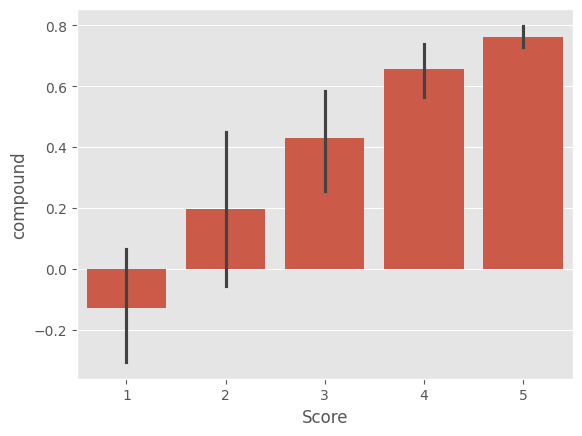

In [34]:
sns.barplot(data  = vaders, x = 'Score' , y = 'compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()


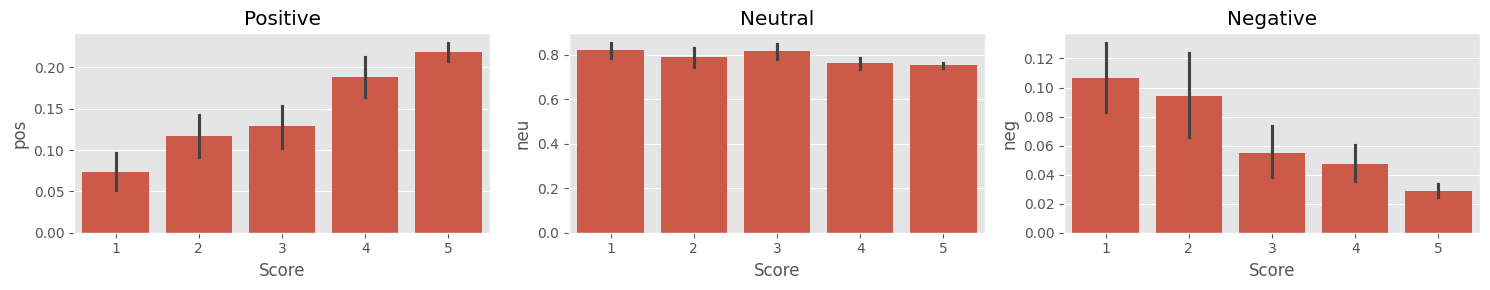

In [35]:
fig , axs = plt.subplots(1,3 , figsize= (15,3))
sns.barplot(data = vaders , x ='Score', y= 'pos',ax= axs[0])
sns.barplot(data = vaders , x ='Score', y= 'neu', ax = axs[1]) 
sns.barplot(data = vaders , x ='Score', y= 'neg', ax =axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()

plt.show()



# Step 02: Roberta Pretrained Model

. Use a model trained of a large corpus of data.

. Transformer model accounts for the words but also the context related to other words 

In [36]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification 
from scipy.special import softmax



In [37]:
from tokenize import tokenize


MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [38]:
#Vader results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [39]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : float(scores[0]),
    'roberta_neu' : float(scores[1]),
    'roberta_pos' : float(scores[2])
}
print(scores_dict)

{'roberta_neg': 0.9763551354408264, 'roberta_neu': 0.020687464624643326, 'roberta_pos': 0.002957369200885296}


In [40]:
def polarity_scores_reborta(example) :
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
       'roberta_neg' : float(scores[0]),
       'roberta_neu' : float(scores[1]),
       'roberta_pos' : float(scores[2])
    }
    return scores_dict


In [41]:
from typing import Text

from regex import B


res = {}
for i , row in tqdm(df.iterrows(), total = len(df)) :
 try :
       text = row['Text']
       myid = row['Id']
       vader_result = sia.polarity_scores(text)
       vader_result_rename = {}
       for key , value in vader_result.items():
         vader_result_rename[f"vader_{key}"] = value 

       roberta_result = polarity_scores_reborta(text)

       both = {**vader_result_rename , **roberta_result}
       res[myid] = both
 except RuntimeError :
     print(f'Broke for id {myid}')


 17%|█▋        | 84/500 [00:10<00:38, 10.72it/s]

Broke for id 83


 38%|███▊      | 188/500 [00:24<00:29, 10.43it/s]

Broke for id 187


100%|██████████| 500/500 [01:09<00:00,  7.18it/s]


In [42]:
result = pd.DataFrame(res).T
result = result.reset_index().rename(columns={'index' :'Id'})
result = result.merge(df,how = 'left')
result.head()


,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Step 03: Compare Scores between Models 

In [43]:
result.columns


Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

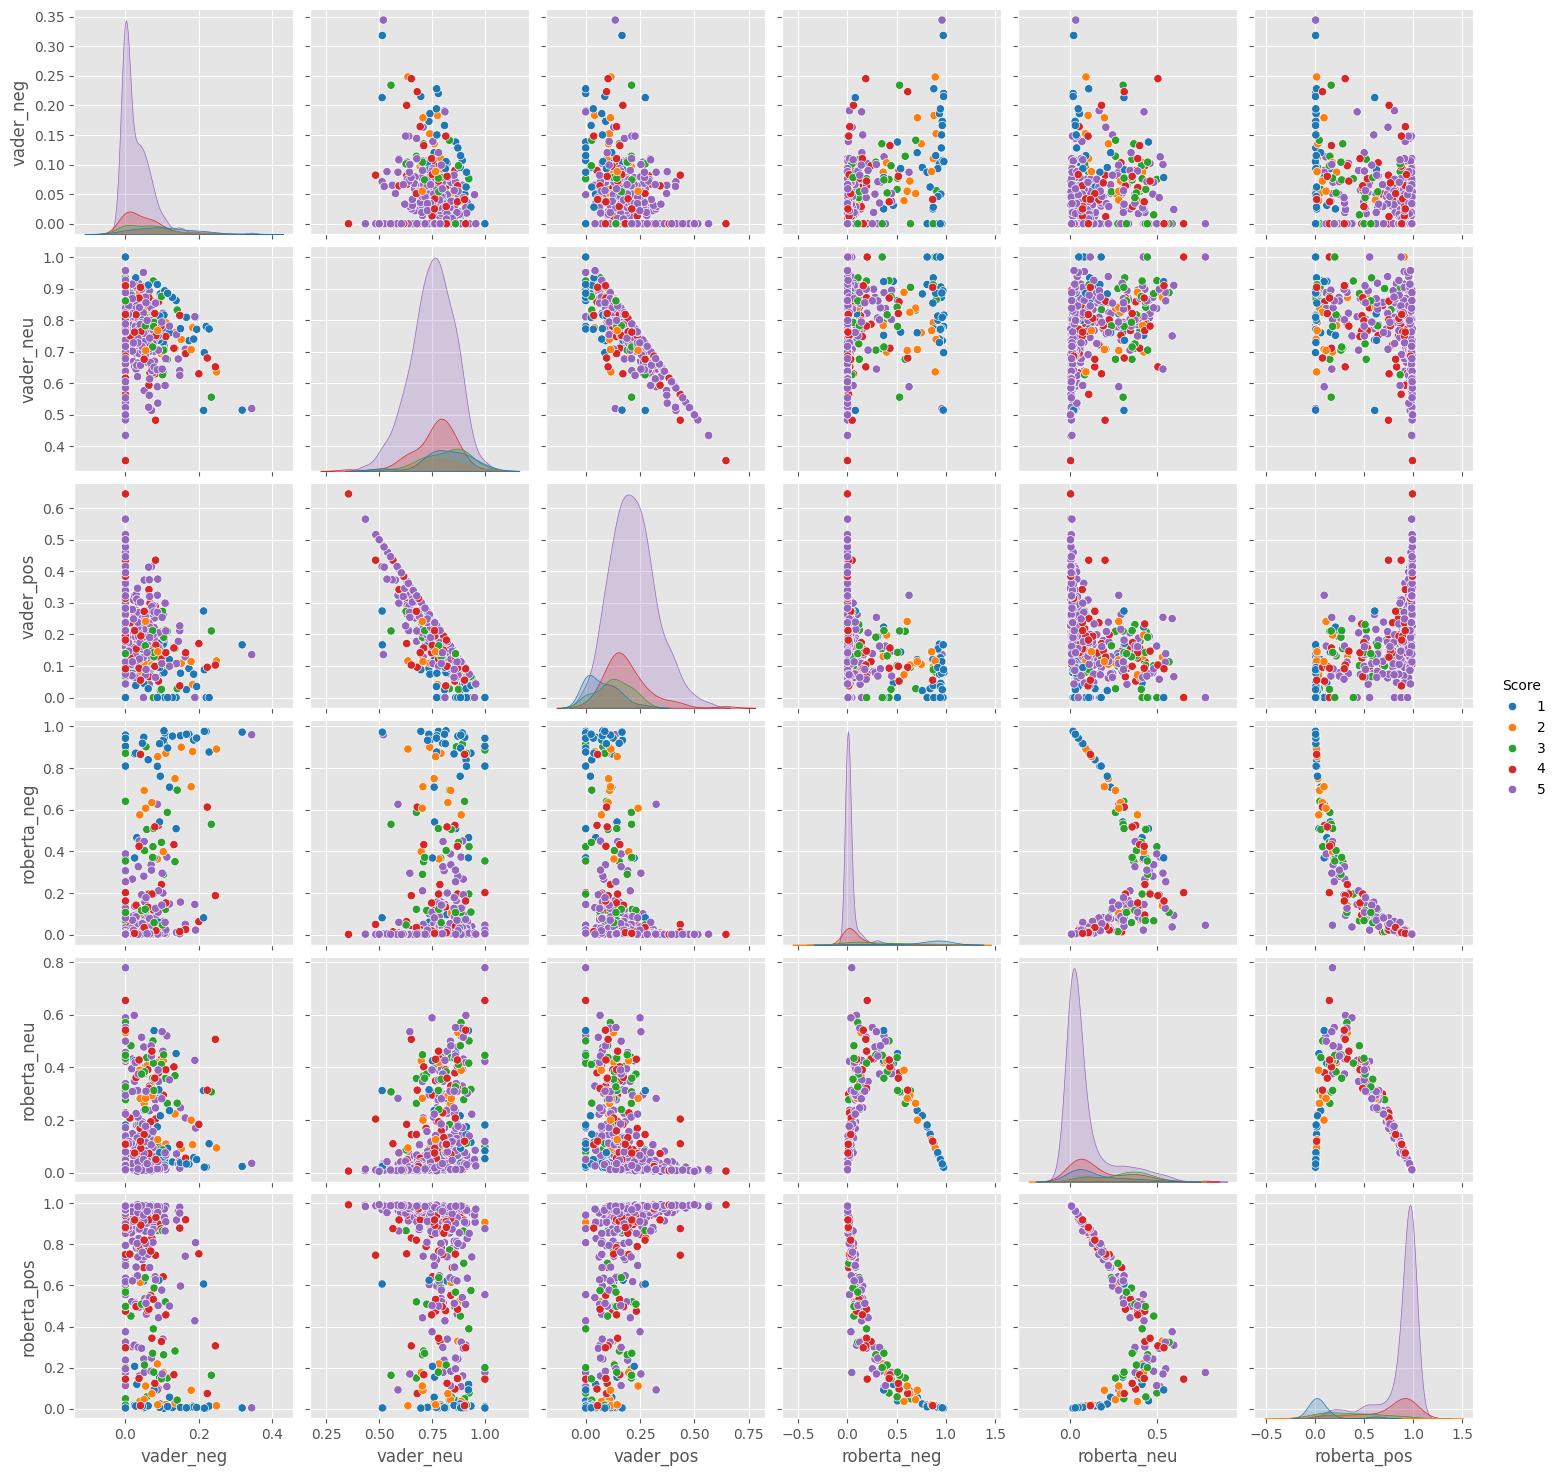

In [44]:
sns.pairplot(data= result , vars = [ 'vader_neg', 'vader_neu', 'vader_pos',
       'roberta_neg', 'roberta_neu', 'roberta_pos'], hue= 'Score' , palette='tab10')

## Step 04 : Review Examples

positve that has review of 1 and the negative that has review of 5

In [45]:
result.query('Score == 1').sort_values('roberta_pos',ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [46]:
result.query('Score == 5').sort_values('roberta_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'